# Dimensionality reduction

In [333]:
!date

Mon  8 Mar 00:45:00 CET 2021


When assessing the model performance, we are interested in two things:
- **prediction** - how accurate our model is when applied to the new data
- **interpretability** - what can it tell us about the relationship between features and predictions, i.e. can we
identify important features


A general rule in machine learning is *'the more the merrier'*. Even the simplest models will generally perform better
when trained on bigger data sets, and with more measured features, one expects to be able to explain more of the
variance in the data. However, working with high dimensional data sometimes can be problematic.

Naturally, the data with fewer dimensions are easier to understand, visualize and interpret. Having a lot of dimensions
can mean that your data points are far away from virtually every other point, which makes the distances between the
data points uninformative - this is often referred to as **the curse of dimensionality**.

To deal with this, before fitting our model we need to perform some sort of dimensionality reduction.

The first possible solution is to look for the effective dimensionality of your data. In data sets where some features
are irrelevant, the effective dimensionality might be much smaller than the actual number of the features. In this case,
 we can use one of the feature selection algorithms to identify only the informative features.

Another situation would be to try to project your original features into a lower dimensional space - ths is what
dimensionality reduction (in strict sense) does. So, while feature selection and dimensionality reduction are similar in
the sense that they both reduce the dimensionality of the data, there is an important difference: **feature selection
selects features to keep or remove from the dataset, whereas dimensionality reduction creates a projection of the data
resulting in entirely new input features.**

### Case scenario 1

To showcase several different feature selection and dimensionality reduction approaches, we will work with the
[Human lung carcinomas microarray dataset](https://doi.org/10.1073/pnas.191502998) from Bhattacharjee et al.


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")

Load the data.

In [2]:
data = pd.read_csv("./data/DatasetA_12600gene.csv", header=0)
data.head()
print(data.shape)
data.columns

(12600, 204)


Index(['probe set', 'AD-043T2-A7-1', 'AD-111T2-A8-1', 'AD-114T1-A9-1 *',
       'AD-115T1-A12-1 *', 'AD-118t1-A13-1', 'AD-119t3-A195-8',
       'AD-120t1-A226-8 *', 'AD-122t3-A197-8', 'AD-123T1-A25-1 *',
       ...
       'COID-COID14t1-A351-6', 'COID-COID16t1-A352-6', 'COID-COID18t1-A353-6',
       'COID-COID3t1-A340-6', 'COID-COID4t1-A341-6', 'COID-COID5t1-A342-6',
       'COID-COID6t1-A343-6', 'COID-COID7t1-A344-6', 'COID-COID8t1-A345-6',
       'COID-COID9t1-A346-6'],
      dtype='object', length=204)

We see there is one categorical variable ('probe set', containing probe i.e. gene names) and 203 numerical ones (samples).
We can summarize numeric columns in the data:

In [3]:
data.describe()

,AD-043T2-A7-1,AD-111T2-A8-1,AD-114T1-A9-1 *,AD-115T1-A12-1 *,AD-118t1-A13-1,AD-119t3-A195-8,AD-120t1-A226-8 *,AD-122t3-A197-8,AD-123T1-A25-1 *,AD-127T1-A14-1,...,COID-COID14t1-A351-6,COID-COID16t1-A352-6,COID-COID18t1-A353-6,COID-COID3t1-A340-6,COID-COID4t1-A341-6,COID-COID5t1-A342-6,COID-COID6t1-A343-6,COID-COID7t1-A344-6,COID-COID8t1-A345-6,COID-COID9t1-A346-6
count,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,...,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000
mean,100.239417,100.899244,91.333506,104.118275,93.203437,93.431129,105.971492,106.203029,95.834106,109.298414,...,121.672475,122.578717,114.799799,121.250127,110.563802,140.542330,100.358783,107.931560,123.265077,109.563598
std,316.449063,338.082066,334.014628,338.423800,339.088615,343.338231,339.469545,339.694939,338.375711,343.273469,...,295.392617,328.506923,339.944349,331.701264,326.656284,294.820844,334.361438,304.089469,326.938184,329.891901
min,-745.160000,-671.920000,-534.135000,-1005.060000,-656.200000,-603.340000,-682.200000,-792.340000,-564.180000,-610.640000,...,-588.680000,-898.380000,-871.820000,-876.930000,-773.500000,-1057.980000,-877.230000,-845.550000,-795.820000,-757.850000
25%,2.440000,11.240000,0.748750,7.915000,-1.980000,-6.040000,3.542500,3.610000,0.080000,11.810000,...,30.690000,13.330000,-2.360000,13.710000,1.680000,49.010000,-9.670000,15.630000,27.360000,-3.920000
50%,27.540000,30.360000,19.705000,30.580000,18.780000,16.190000,29.160000,28.780000,20.595000,35.320000,...,54.450000,42.200000,29.320000,41.330000,29.070000,71.050000,16.170000,38.160000,53.150000,25.710000
75%,92.400000,79.200000,69.256250,88.703750,71.920000,74.700000,94.347500,94.330000,75.585000,92.920000,...,114.670000,115.700000,111.610000,112.000000,102.980000,133.110000,87.310000,98.850000,113.690000,106.202500
max,7322.580000,7077.040000,8056.020000,7132.050000,7254.320000,6935.870000,6715.070000,7147.730000,6935.240000,7202.390000,...,8751.660000,7355.160000,8011.270000,8129.800000,7917.870000,8726.120000,8064.240000,7555.490000,8274.780000,8073.710000


For downstream work, we will transform the data to have samples as rows and genes (probes) as columns.

In [25]:
# input matrix with features as columns
dt = data.transpose()
cols = dt.iloc[0]
dt = dt.iloc[3:,]
dt.columns = cols
dt = dt.apply(pd.to_numeric, errors='coerce')
dt.head()

probe set,AFFX-MurIL2_at,AFFX-MurIL10_at,AFFX-MurIL4_at,AFFX-MurFAS_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,...,100_g_at,101_at,102_at,103_at,104_at,105_at,106_at,107_at,108_g_at,109_at
AD-114T1-A9-1 *,-2.175,-2.21,-0.060,6.320,-1.775,-16.53,-3.610,16.410,-17.970,-57.020,...,67.44,14.610,10.875,10.615,35.140,1.745,29.710,10.465,-42.63,73.735
AD-115T1-A12-1 *,-1.540,21.75,5.835,23.815,-24.785,-12.89,-4.485,19.500,-21.445,-47.205,...,133.94,9.615,27.355,30.860,48.710,10.355,40.845,54.615,-71.38,65.435
AD-118t1-A13-1,-9.070,3.08,-1.980,17.260,-10.090,-15.15,-18.190,13.210,-13.130,-39.470,...,99.23,-14.140,23.340,6.120,33.460,-10.090,40.550,16.250,-48.59,39.540
AD-119t3-A195-8,-16.580,-20.09,-8.390,4.490,-18.920,-20.09,-8.390,16.190,-38.820,-56.380,...,127.33,13.850,8.000,75.870,37.260,-11.900,24.390,54.810,-47.02,59.490
AD-120t1-A226-8 *,-15.895,10.88,1.610,23.845,-21.980,-29.00,-3.865,23.635,-19.010,-65.195,...,189.52,13.755,25.300,12.680,53.485,6.920,48.120,42.560,-81.71,39.965


Outlier samples can influence the model performance. We identify potential outliers as those with mean z value higher
than 1.

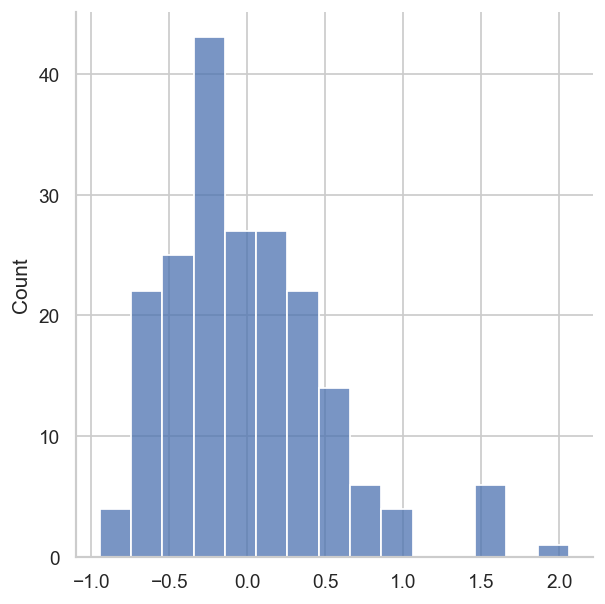

In [26]:
from scipy.stats import zscore

dtzscore = dt.apply(zscore).mean(axis=1)
sns.displot(dtzscore)

Whether to remove the outliers is not always straightforward, and it largely depends on the data, the used model and
the question we want to answer. If unsure, the bast thing to do would be to fit the same model with or without outliers
and see how it influences the model performance. Here we remove the outliers.

In [6]:
#outliers = dtzscore[abs(dtzscore)>1.5].index
#print(outliers)
#dt = dt.drop(outliers, axis=0)
#dt.shape

Index(['AD-338t1a-A121-3 *', 'AD-351t1-A127-3', 'SMCL-SMCL8t1-A356-6',
       'COID-2260-A304-5', 'COID-4518-A305-5', 'COID-9794-A300-5',
       'COID-COID5t1-A342-6'],
      dtype='object')


(194, 12600)

Classes of samples are described in the publication:


* normal lung (NL)
* neuroendocrine tumors
  * small-cell lung cancer (SMCL)
  * pulmonary carcinoids (COID)
* squamous cell lung carcinoma (SQ)
* adenocarcinomas (AD)

We extract tumor class indicators from sample names.

In [27]:
samples = pd.Series(list(dt.index)[0:])
classes = samples.str.extract(r'(AD|NL|SMCL|SQ|COID)')
classes.value_counts()

AD      137
SQ       21
COID     20
NL       17
SMCL      6
dtype: int64

Now we can summarize the expression of each gene by tumor class.

In [28]:
dt['Class'] = classes.values
dt.groupby(['Class']).mean()

probe set,AFFX-MurIL2_at,AFFX-MurIL10_at,AFFX-MurIL4_at,AFFX-MurFAS_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,...,100_g_at,101_at,102_at,103_at,104_at,105_at,106_at,107_at,108_g_at,109_at
Class,,,,,,,,,,,,,,,,,,,,,
AD,-9.087269,4.543054,0.928406,19.269064,-13.156089,-18.529660,-5.172013,24.822834,-21.958954,-52.713260,...,133.349664,7.258388,19.817749,15.594775,44.188588,2.528340,36.428242,30.383193,-58.709681,69.901746
COID,13.829500,28.331500,18.926000,42.112500,-5.235500,-9.738500,14.539000,35.837500,-18.217000,-46.033500,...,212.381500,9.659500,31.112000,48.095000,69.513500,20.926500,34.480500,48.644000,-24.081500,96.400000
NL,-18.127647,-7.629412,-10.631176,13.154706,-32.394706,-44.083529,-7.740000,14.532353,-31.537647,-57.608235,...,105.974118,-7.731765,2.073529,-4.917059,34.986471,-8.917059,31.642353,34.871765,-86.042941,55.991176
SMCL,13.911667,21.578333,12.183333,32.351667,-12.508333,-26.431667,-0.141667,32.843333,-23.228333,-57.068333,...,142.985000,5.060000,34.220000,28.976667,78.450000,17.088333,57.003333,46.591667,-52.905000,74.198333
SQ,-18.898571,-9.160000,-14.440000,4.210476,-28.203333,-37.127619,-16.997143,-0.824286,-36.459048,-59.486667,...,135.947143,3.051905,4.211429,-4.859524,23.317619,-12.938095,39.040476,24.648571,-89.865714,68.809048


We could attempt, for example, to cluster the samples and identify the important genes (gene signatures) for each class.
However, as the number of features is very high, this would not work very well. We want to preselect the features first.
In the original publication, authors did this by simply selecting variable genes using a standard deviation threshold
of 50 expression units. We will show this approach and several alternative models.

To evaluate variable feature selection step, we split data into training and test dataset.

In [209]:
from sklearn.model_selection import train_test_split

target_column = ['Class']
predictors = list(set(list(dt.columns))-set(target_column))
X = dt[predictors].values
Y = dt[target_column]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)
print(np.unique(Y_train)); print(np.unique(Y_test))

(140, 12600)
(61, 12600)
['AD' 'COID' 'NL' 'SMCL' 'SQ']
['AD' 'COID' 'NL' 'SMCL' 'SQ']


## Feature selection

Feature selection is typically done when working with datasets that have many more features than observations.
For example, $$n$$ patient samples and for each we have $$p$$ measured characteristics, e.g. genes expression, and
$$p>>n$$. Why is this problematic, and why our models generally won't perform well with this kind of data?
Because there is essentially not enough observations to cover all the possible combinations of features.

Several most commonly used feature selection methods to consider in this case are:
- variance feature selection
- lasso
- ridge
- elastic net

### Variance feature selection

The simplest approach for selecting important features would be to simply select those that have high variance.
Intuitively, low variance means the values of the feature are very similar, and will not help the model very much to
discriminate different samples, classes of samples or outcomes. Therefore, by retaining only the high variable features,
our model will be less likely to biased.

There are 12600 features in our data. We inspect the distribution of their variance and perform feature selection.

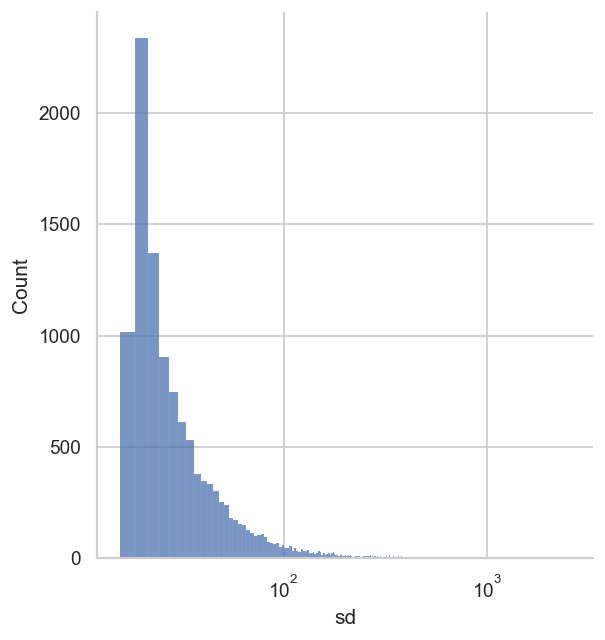

In [104]:
sns.displot(X.std(axis=0)).set(xlabel='sd',xscale='log')

We need to decide on a threshold for which features to exclude. In the original publication, the authors have used a sd
threshold of 50 expression units to select the around 3.5k most variable features. We repeat the same here.

In [181]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(50**2)
selector.fit(X)
X[:,selector.get_support()].shape

(201, 3552)

We selected 3552 most variable features. Now we evaluate how discriminative they are by fitting a logistic regression
model on the train-test split.

In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# fit a model
logreg = LogisticRegression(penalty='none') # default is l2, which we will discuss later
lr = logreg.fit(X_train[:,selector.get_support()], Y_train.values.ravel())

# predictions on test set
pred_train_lr = lr.predict(X_train[:,selector.get_support()])
print(accuracy_score(Y_train,pred_train_lr))

# predictions on train set
pred_test_lr = lr.predict(X_test[:,selector.get_support()])
print(accuracy_score(Y_test,pred_test_lr))

1.0
0.9508196721311475


The important downside of this simple feature selection approach is that it only considers the input features and
doesn't take the dependent variable into account. It is therefore primarily useful for the unsupervised modelling.

Another downside is that features with higher absolute values will tend to have higher variance (a nice technical term
for this is *heteroscedasticity*), so that the performance of any model we choose downstream will be dominated by the
most highly expressed genes. We can mitigate this by scaling the features. Try this and see how it affects the model
performance.

### Lasso

In [217]:
from sklearn.preprocessing import StandardScaler

lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=int(1e6))
lsr = lasso.fit(X_train, Y_train.values.ravel())

# predictions on test set
pred_train_lsr = lsr.predict(X_train)
print(accuracy_score(Y_train,pred_train_lsr))

# predictions on train set
pred_test_lsr = lsr.predict(X_test)
print(accuracy_score(Y_test,pred_test_lsr))

1.0
0.7377049180327869


If we have very few features and score is poor, it's likely that we are under-fitting or not generalizing enough.
On the other hand, if we have many features, and the train score is good, but the test score is poor, we are
over-fitting.

Important parameter to consider during regularization is `C`, the inverse of regularization strength. It must have a
positive value, and smaller values specify stronger regularization. We can evaluate model performance with different
values of `C`.

In [309]:
def eval_reg(
        x_train, x_test, y_train, y_test,
        cs = np.logspace(-2, 8, 10), penalty = 'l1', solver = 'liblinear', l1_ratio = None):

  from time import time

  print("Computing regularization path ...")
  start = time()
  reg = LogisticRegression(penalty=penalty, solver=solver, l1_ratio=l1_ratio, max_iter=int(1e6), warm_start=True)
  coefs_ = []
  acc_train_ = []
  acc_test_ = []
  for c in cs:
    reg.set_params(C=c)
    regfit = reg.fit(x_train, y_train.values.ravel())
    coefs_.append(regfit.coef_.ravel().copy())

    pred_train = regfit.predict(X_train)
    acc_train_.append(accuracy_score(y_train,pred_train))

    pred_test = regfit.predict(x_test)
    acc_test_.append(accuracy_score(y_test,pred_test))

  print("This took %0.3fs" % (time() - start))
  coefs_ = np.array(coefs_)

  ldt = pd.DataFrame(data={
      'log(C)' : np.log10(cs),
      'train' : acc_train_,
      'test' : acc_test_
  }).melt(id_vars='log(C)',value_name="accuracy",var_name="data")
  sns.lineplot(x="log(C)", y="accuracy", hue="data", data=ldt)

  return coefs_

Computing regularization path ...
This took 12.083s


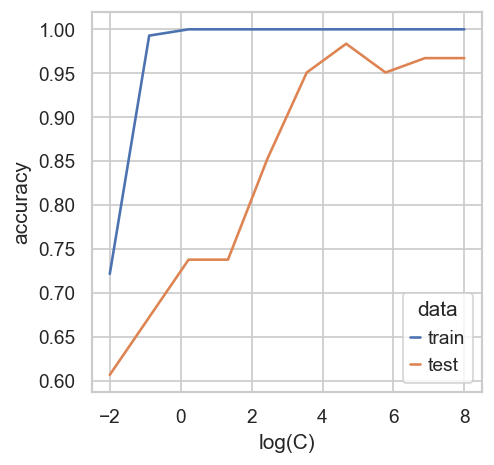

In [279]:
l1_coeffs = eval_reg(X_train, X_test, Y_train, Y_test, penalty="l1")

Inspect coefficients.

In [312]:
cdt = pd.DataFrame(data=l1_coeffs).set_index(np.logspace(-2, 8, 10))
cdt.transpose().abs().describe()

,1.000000e-02,1.291550e-01,1.668101e+00,2.154435e+01,2.782559e+02,3.593814e+03,4.641589e+04,5.994843e+05,7.742637e+06,1.000000e+08
count,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000
mean,0.000005,0.000109,0.000318,0.000584,0.001681,0.005096,0.016248,0.036991,0.051328,0.054527
std,0.000368,0.003261,0.008922,0.014197,0.036097,0.058042,0.088691,0.121699,0.139783,0.132040
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004913,0.007281
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004076,0.018408,0.021298
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031442,0.050703,0.054718
max,0.061122,0.260151,0.736494,1.019440,4.103736,3.959141,2.972377,4.971020,11.127993,5.880772


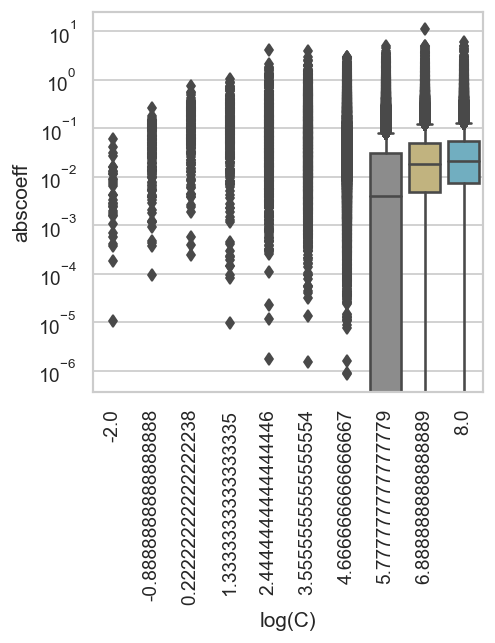

In [306]:
def plot_coeffs_dist(coeffs, cs=np.logspace(-2, 8, 10)):
    pd.DataFrame(data=coeffs).set_index(cs)
    cdt['C'] = cdt.index
    cdtm = cdt.melt( id_vars='C',value_name="coeff")
    cdtm['log(C)'] = np.log10(cdtm['C'])
    cdtm['abscoeff'] = abs(cdtm['coeff'])
    sns.boxplot(x='log(C)',y='abscoeff',data=cdtm)
    plt.yscale('log')
    plt.xticks(rotation=90)
    plt.show()

plot_coeffs_dist(l1_coeffs)

### Ridge

Evaluate for different values of C.

Computing regularization path ...
This took 36.160s


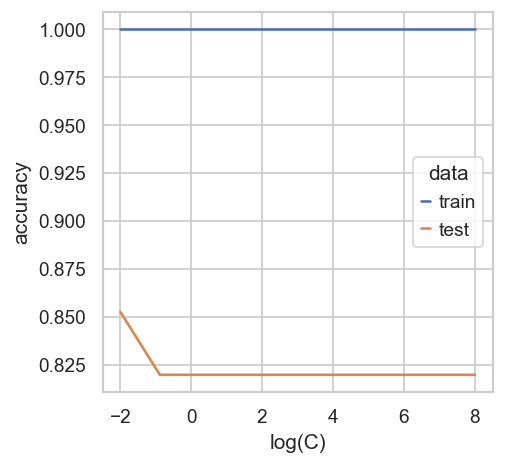

In [300]:
l2_coeffs = eval_reg(X_train, X_test, Y_train, Y_test, penalty="l2")

Inspect coefficients.

In [303]:
cdt = pd.DataFrame(data=l2_coeffs).set_index(np.logspace(-2, 8, 10))
cdt.transpose().abs().describe()
plot_coeffs_dist(l2_coeffs)

,1.000000e-02,1.291550e-01,1.668101e+00,2.154435e+01,2.782559e+02,3.593814e+03,4.641589e+04,5.994843e+05,7.742637e+06,1.000000e+08
count,6.300100e+04,6.300100e+04,6.300100e+04,6.300100e+04,6.300100e+04,6.300100e+04,6.300100e+04,6.300100e+04,6.300100e+04,6.300100e+04
mean,1.202627e-03,2.261801e-03,3.393215e-03,4.504253e-03,8.575177e-03,6.142428e-02,7.411319e-01,9.519841e+00,1.229016e+02,1.587281e+03
std,2.351986e-03,4.383644e-03,9.349452e-03,8.619497e-02,1.108602e+00,1.431797e+01,1.849238e+02,2.388383e+03,3.084716e+04,3.984064e+05
min,2.951128e-09,8.399071e-09,6.848577e-08,1.024319e-07,5.947320e-08,2.824072e-08,2.294984e-08,2.270367e-08,2.240080e-08,2.240831e-08
25%,3.365912e-04,5.960293e-04,8.705097e-04,1.085287e-03,1.082782e-03,1.150034e-03,1.150457e-03,1.097393e-03,1.163311e-03,1.086584e-03
50%,7.387346e-04,1.338098e-03,1.962400e-03,2.454357e-03,2.433154e-03,2.605961e-03,2.607304e-03,2.479218e-03,2.650272e-03,2.439814e-03
75%,1.398440e-03,2.599078e-03,3.822576e-03,4.763917e-03,4.743627e-03,5.038541e-03,5.041867e-03,4.875350e-03,5.189129e-03,4.758974e-03
max,9.808676e-02,1.928559e-01,1.668101e+00,2.154435e+01,2.782559e+02,3.593814e+03,4.641589e+04,5.994843e+05,7.742637e+06,1.000000e+08


### Elastic net

We need to specify the elastic net mixing parameter `l1_ratio` - setting `l1_ratio=1` is equivalent to using L1
regularization (lasso), while `l1_ratio=0` is equivalent to using L2 regularization (ridge).

Computing regularization path ...
This took 521.988s


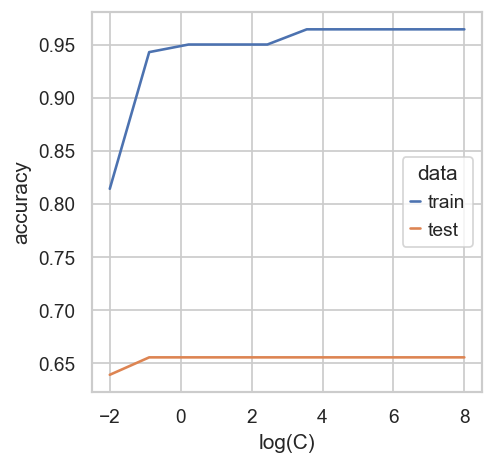

In [311]:
elnet_coeffs = eval_reg(X_train, X_test, Y_train, Y_test, penalty="elasticnet", l1_ratio=0.5, solver="saga")

Inspect coefficients.

In [ ]:
cdt = pd.DataFrame(data=elnet_coeffs).set_index(np.logspace(-2, 8, 10))
cdt.transpose().abs().describe()
plot_coeffs_dist(elnet_coeffs)


## Dimensionality reduction

We might be working with a dataset that have both large number of observations and features. A typical example would be
single cell experiments, with tens of thousands of cells and tens of thousands of features (gene expression, methylation,
 or ChIP signal etc.) measured in each cell.

What options are there?  
- PCA
- tSNE
- UMAP

### PCA

PCA is a linear transformation method that identifies the directions (principal components) that maximize the variance
of the data.

For a simplified step-by-step explanation of maths behind PCA, check out [StatQuest video](https://youtu.be/FgakZw6K1QQ).

PCA is using a method called singular value decomposition (SVD) to transform our original data matrix. Essentially, it
computes independent (i.e. perpendicular) singular vectors (eigenvectors) $$\nu$$ along which the data are spread.
Each eigenvector has the corresponding singular value (eigenvalue) $$\lambda$$, which is the sum of squared distances
between the data points projected on the eigenvector and the center of the data.

$$ \sum_{}{}{\nu}=\lambda\nu $$

Eigenvectors associated with eigenvalues that are much higher than others contain more information about our data
distribution. Vice versa, eigenvalues that are close to 0 are less informative, and we usually drop those to reduce
the dimensionality of our data.

To generate a representation of the data in the lower-dimensional space, PCA collects eigenvectors with the highest
eigenvalues in an eigenvector matrix $$ W $$ and transform the data into the new subspace by multiplication.

$$ y=W^{T}\times x $$

We first need to standardize features by removing the mean and scaling to unit variance. Again, this is necessary
because a feature that has orders of magnitude larger variance than others might dominate the model.

[ -9.91415361   2.38426978  -1.60014609 ...  29.65944587 -62.86861495
  70.18437732]
[17.60989243 17.99073575 16.04323055 ... 42.59516681 42.0765482
 28.65533722]


array([1., 1., 1., ..., 1., 1., 1.])

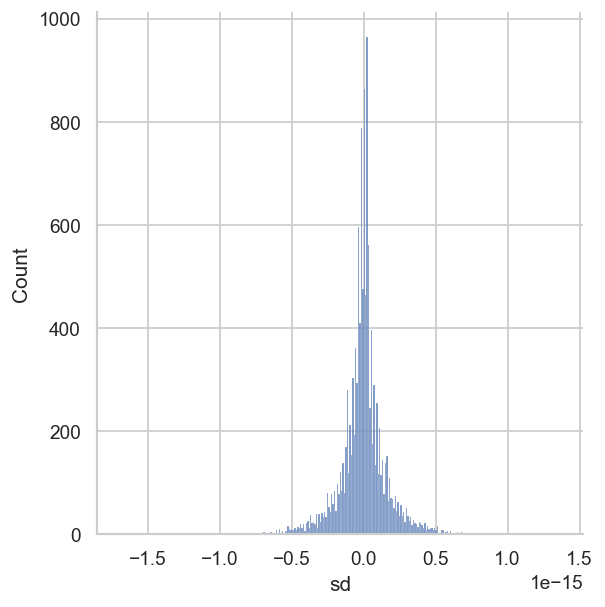

In [139]:
tmat = dt.drop('Class', axis=1)
X = StandardScaler().fit_transform(tmat)

#scaled data has mean 0 and var 1
sns.displot(X.mean(axis=0)).set(xlabel='sd')
X.std(axis=0)

PCA

In [15]:
from sklearn.decomposition import PCA

# build PCA model 
pca = PCA(n_components=6)

# fit and transform the data to the model
pca_reduced_data = pca.fit_transform(X)

# inspect the shape
pca_reduced_data.shape

(194, 6)

Plot the data projected on the first two principal components

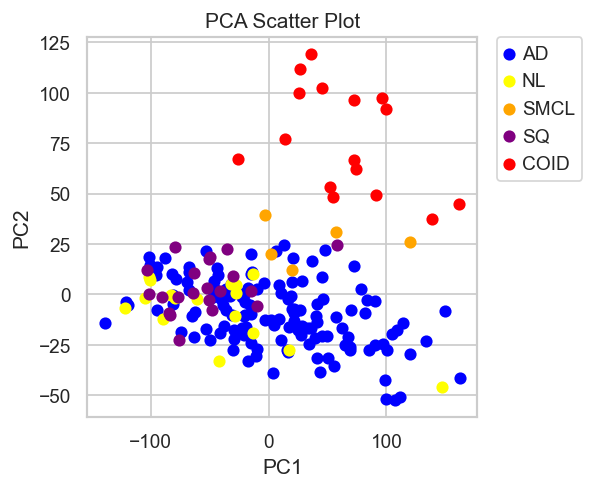

In [16]:
colors = ['blue', 'yellow', 'orange', 'purple', 'red']
cl = ['AD', 'NL', 'SMCL', 'SQ', 'COID']
for i in range(len(colors)):
    ind = classes == cl[i]
    x = pca_reduced_data[:,0][ind.values[:,0]]
    y = pca_reduced_data[:,1][ind.values[:,0]]
    plt.scatter(x, y, c=colors[i])
plt.legend(cl, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Scatter Plot")
plt.show()

We see that all samples cannot be separated using the two first principal components, which account for less than 40%
of the variance in the data.

[0.33301036 0.06756122 0.04097646 0.0306478  0.02255248 0.0158108 ]


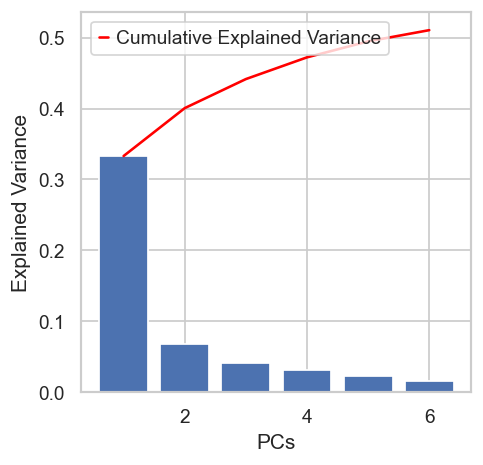

In [17]:
print(pca.explained_variance_ratio_)
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained Variance')
plt.xlabel('PCs')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

Squamous cell lung carcinoma (SQ) and adenocarcinoma (AD) samples are largely overlapping with the normal lung samples,
whereas the two neuroendocrine tumors are separating better, so we only select the former and repeat the same exercise.

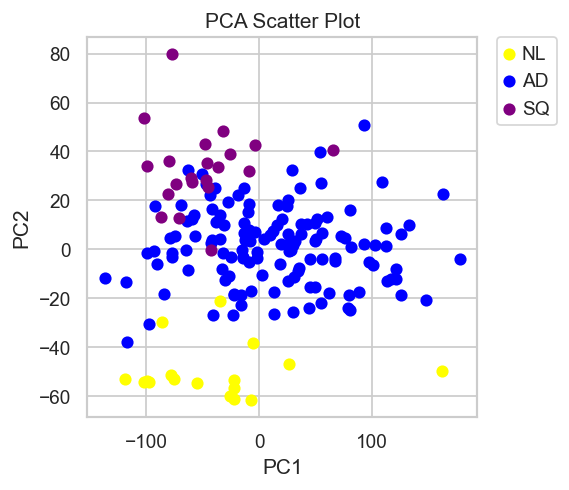

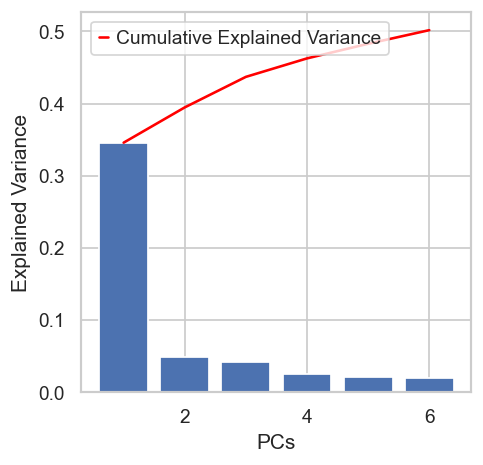

In [18]:
selected = classes.isin(['NL','SQ','AD'])
tmatfilt = tmat.filter(regex=r'(NL|SQ|AD)', axis=0)

# scale
scaler = StandardScaler()
X = StandardScaler().fit_transform(tmatfilt)

# classes from sample names
samples = pd.Series(list(tmatfilt.index))
classes = samples.str.extract(r'(NL|SQ|AD)')
classes.value_counts()

# build PCA model 
pca = PCA(n_components=6)

# fit and transform the data to the model
pca_reduced_data = pca.fit_transform(X)

# plot
colors = ['yellow', 'blue', 'purple']
cl = ['NL', 'AD', 'SQ']
for i in range(len(colors)):
    ind = classes == cl[i]
    x = pca_reduced_data[:,0][ind.values[:,0]]
    y = pca_reduced_data[:,1][ind.values[:,0]]
    plt.scatter(x, y, c=colors[i])
plt.legend(cl, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Scatter Plot")
plt.show()

# variance
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained Variance')
plt.xlabel('PCs')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')
plt.show()

Now the two tumor types are better separated from the normal sample, even though they are still overlapping.
Accordingly, we see that the PC2, along which they are separated, explains a very small proportion of variance between
these samples.

In [19]:
pca.explained_variance_ratio_

array([0.34574274, 0.04890907, 0.04232571, 0.02559767, 0.02027156,
       0.01888026])

We do the same for the two neuroendocrine tumors.

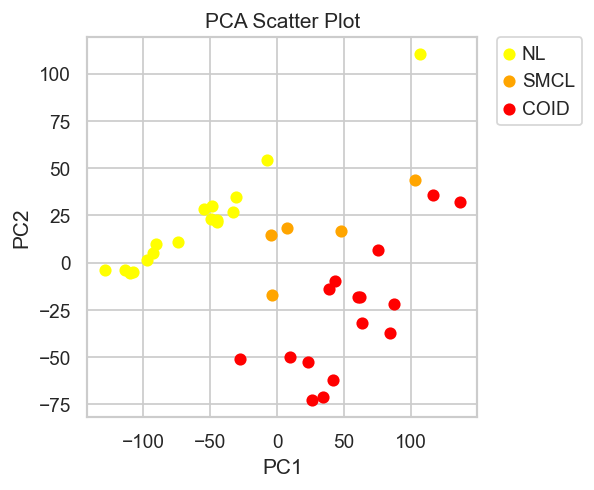

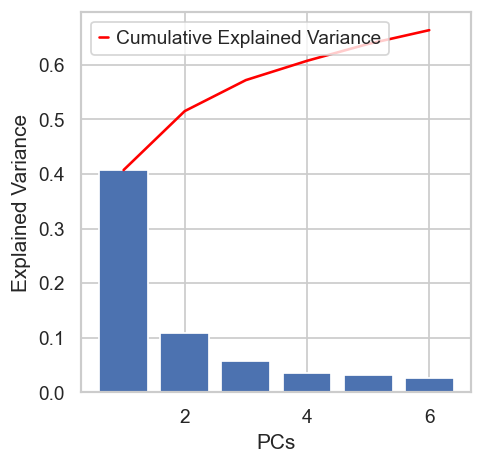

In [20]:
selected = classes.isin(['NL','SMCL','COID'])
tmatfilt = tmat.filter(regex=r'(NL|SMCL|COID)', axis=0)

# scale
scaler = StandardScaler()
X = StandardScaler().fit_transform(tmatfilt)

# classes from sample names
samples = pd.Series(list(tmatfilt.index))
classes = samples.str.extract(r'(NL|SMCL|COID)')
classes.value_counts()

# build PCA model 
pca = PCA(n_components=6)

# fit and transform the data to the model
pca_reduced_data = pca.fit_transform(X)

# plot
colors = ['yellow', 'orange', 'red']
cl = ['NL', 'SMCL', 'COID']
for i in range(len(colors)):
    ind = classes == cl[i]
    x = pca_reduced_data[:,0][ind.values[:,0]]
    y = pca_reduced_data[:,1][ind.values[:,0]]
    plt.scatter(x, y, c=colors[i])
plt.legend(cl, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Scatter Plot")
plt.show()

# variance
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained Variance')
plt.xlabel('PCs')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')
plt.show()

In this case the separation is better.

In [352]:
pca.explained_variance_ratio_

array([0.41783969, 0.10022737, 0.05175384, 0.03408126, 0.02801462,
       0.02252216])

An important point to make here is that in PCA we are trying to find the axes with maximum variances where the data is
most spread. This is not a classification algorithm, and labeling the points is completely independent of the model
building and its performance. A related linear transformation method that maximizes the variance in the data, and
additionally finds the directions that maximize the separation between different classes is called Multiple Discriminant
Analysis (MDA).

When it comes to interpretability of PCA models, we already mentioned that the PCs represent directions of variance in
the data. We can also identify the key variables (here, genes) that contribute to the explanation of most variance in
the data set. The importance of each feature is reflected by the magnitude of the corresponding values in the
eigenvectors, where higher magnitude means higher contribution of that feature to the PC.

Let’s find the most important features.

[ 5065  1943  2362  8832  3808  1668  3386  8335  3247 10032  4870 10238
 10388  3430  7571  9152  6990  6008  3323   669]
[0.01338653 0.01338915 0.01339742 0.01340845 0.013412   0.01342095
 0.0134235  0.01342536 0.01343005 0.0134302  0.01343118 0.01344143
 0.01344949 0.01345625 0.01347426 0.01347704 0.01347816 0.01348288
 0.01352158 0.01365096]
['33765_at', '33538_at', '35394_at', '37349_r_at', '39954_r_at', '32308_r_at', '38574_at', '35772_at', '38195_at', '40943_at', '32733_at', '41509_at', '41843_r_at', '38857_r_at', '32258_r_at', '38387_at', '40121_at', '37223_at', '38511_at', '32386_at']


Text(0, 0.5, 'Gene')

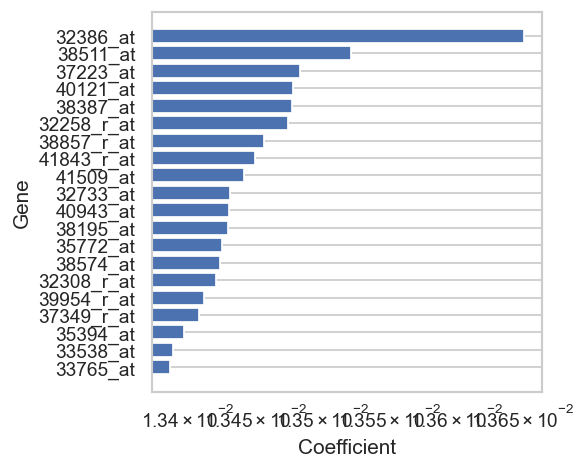

In [21]:
# get top genes to plot
ids = np.argsort(abs(pca.components_)[0,:],axis=0)[-20:]
print(ids)
coeff = abs(np.transpose(pca.components_)[ids,:][:,0])
print(coeff)
labels = np.asarray(tmatfilt.columns)[ids].tolist()
print(labels)

plt.barh(labels,coeff)
plt.xscale('log',base=10)
plt.xlabel('Coefficient')
plt.ylabel('Gene')

In [354]:
# get gene names
geneannot = pd.read_table("data/Annotation_genes.tsv")
